In [1]:
%%capture installation

import sys
sys.path.insert(0, '..')
import robustbench
from robustbench.data import load_cifar10
from robustbench.utils import load_model, clean_accuracy

import torchattacks

import os
import argparse
import datetime

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.optim as optim
import yaml
from art.attacks.evasion import DeepFool, FastGradientMethod
from art.estimators.classification import PyTorchClassifier

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from typing import Callable, Tuple, Dict
from pathlib import Path
import pytorch_lightning as pl
from torch import nn

from dataloader import load_mnist
from models.autoencoder import (ANNAutoencoder, BaseAutoEncoder,
                                CelebAAutoencoder, CIFAR10Autoencoder, CIFAR10VAE,
                                CIFAR10LightningAutoencoder)
from models.classifier import (CelebAClassifier, CIFAR10Classifier,
                                MNISTClassifier)

from attacks import ATTACK_MAPPINGS
from attacks.art_attack import execute_attack, get_models, get_xyz, hybridize
from attacks.plot_attack import plot_adversarial_images, plot_robust_accuracy
from dataloader import DATALOADER_MAPPINGS

In [19]:
class Args:
    batch_size = 300
    attack_name = "cnw"
    device  = "cuda"
    model_name = "cifar10_cnn_1"
    ae_name = "cnn_256"
    plot = False
    plot_dir = "./plots"
    # kwargs = {"batch_size": 32, "nb_grads": 5, "epsilon": 1e-05} # deepfool
    kwargs = {"eps": 0.1} # pgd and fgsm
    kwargs = {}

args = Args()

In [27]:
import pickle
attack_name = ATTACK_MAPPINGS.get(args.attack_name)
dataset_name = args.model_name.split("_")[0]
print(f"Working on the dataset: {dataset_name}!!!!!")

with open(f"./configs/{dataset_name}.yml", "r") as f:
    config = yaml.safe_load(f)

classifier_model, autoencoder_model, config = get_models(args)
print(f"Loaded classifier and autoencoder models in eval mode!!!!!")

if dataset_name+".pkl" in os.listdir("./objects/"):
    fileObj = open("./objects/"+dataset_name+".pkl", 'rb')
    train_dataloader = pickle.load(fileObj)["data"]
    fileObj.close()
else:
    train_dataloader, _, _ = DATALOADER_MAPPINGS[config["dataset_name"]](batch_size=args.batch_size)
    obj = {"data": train_dataloader}
    fileObj = open("./objects/"+dataset_name+".pkl", 'wb')
    pickle.dump(obj, fileObj)
    fileObj.close()
print(f"Loaded dataloader!!!!!")

Working on the dataset: cifar10!!!!!


/home/harsh/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/harsh/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/harsh/Documents/projects/Semantic-Preserving-Adversarial-Attack/models/autoencoder.py:844: UnderReviewWarning: The feature AE is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  super().__init__(input_height=inpu

Loaded classifier and autoencoder models in eval mode!!!!!
Loaded dataloader!!!!!


In [28]:
x, y, z = get_xyz(args, autoencoder_model, train_dataloader)
images, labels = next(iter(train_dataloader))
acc = clean_accuracy(classifier_model, images.to(device), labels.to(device))
print('Acc: %2.2f %%'%(acc*100))

Acc: 99.00 %


In [29]:
from torchattacks import FGSM, PGD, DeepFool, CW, Square, AutoAttack, SparseFool

classifier_model = classifier_model.to("cpu")
# images = images.to(device)
# labels = labels.to(device)
print(classifier_model.device, images.device, labels.device)
# attacks = [FGSM, PGD, DeepFool, Square, AutoAttack, SparseFool]
attacks = [CW]
for attack in attacks:
    atk = attack(classifier_model)
    adv_images = atk(images, labels)
    adv_acc = clean_accuracy(classifier_model, adv_images, labels)
    print(f'{attack.__name__} Acc: %2.2f %%'%(adv_acc*100))

cpu cpu cpu
CW Acc: 7.00 %


In [37]:
adv_images

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan

In [30]:
import torchvision
def plot_images(images):
    plt.figure(figsize=(20, 2))
    images = torch.Tensor(images).reshape(-1, 3, 32, 32)
    # i = 1
    # for image in images:
    #     plt.subplot(5, 5, i, xticks=[], yticks=[])
    #     plt.imshow(np.transpose(image, (1, 2, 0)))
    #     i = i + 1

    #     if i == 26:
    #         break
    grid = torchvision.utils.make_grid(images, nrow=10, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

def plot_batch(images):
    plt.figure(figsize=(20, 10))
    images = torch.Tensor(images).reshape(-1, 3, 32, 32)
    grid = torchvision.utils.make_grid(images, nrow=10, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

start = 0
end   = 10

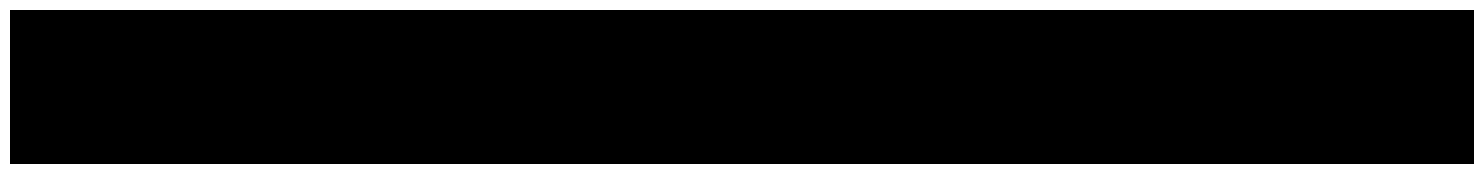

In [31]:
plot_images(adv_images[start: end].detach().cpu())

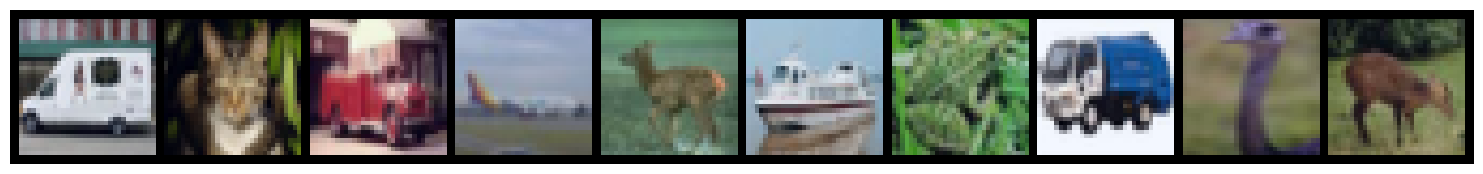

In [32]:
plot_images(x[1][start: end])

tensor(nan, device='cuda:0')
tensor(2.7537, device='cuda:0')


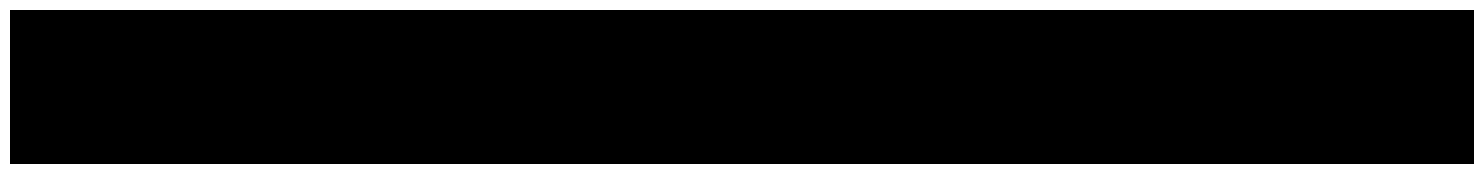

In [34]:
delta = adv_images.to(device) - x[0]
print(torch.max(torch.abs(delta)))
print(torch.norm(x[0], float('inf')))
plot_images(delta[start: end].detach().cpu())

In [83]:
hybrid_classifier_model = nn.Sequential(
            autoencoder_model.decoder,
            classifier_model.model
        ).to(device)

In [61]:
# attacks = [FGSM, PGD, DeepFool, SparseFool]
attacks = [FGSM]
for attack in attacks:
    atk = attack(hybrid_classifier_model, eps=1e-20)
    adv_images_spae = atk(z[0].to(device), labels.to(device))
    adv_acc = clean_accuracy(hybrid_classifier_model, adv_images_spae.to(device), labels.to(device))
    print(f'{attack.__name__} Acc: %2.2f %%'%(adv_acc*100))

FGSM Acc: 50.00 %


In [62]:
spae_images = autoencoder_model.decoder(adv_images_spae).detach().cpu()

In [63]:
import torchvision
def plot_images(images):
    plt.figure(figsize=(20, 2))
    images = torch.Tensor(images).reshape(-1, 3, 32, 32)
    # i = 1
    # for image in images:
    #     plt.subplot(5, 5, i, xticks=[], yticks=[])
    #     plt.imshow(np.transpose(image, (1, 2, 0)))
    #     i = i + 1

    #     if i == 26:
    #         break
    grid = torchvision.utils.make_grid(images, nrow=10, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

def plot_batch(images):
    plt.figure(figsize=(20, 10))
    images = torch.Tensor(images).reshape(-1, 3, 32, 32)
    grid = torchvision.utils.make_grid(images, nrow=10, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

start = 0
end   = 10

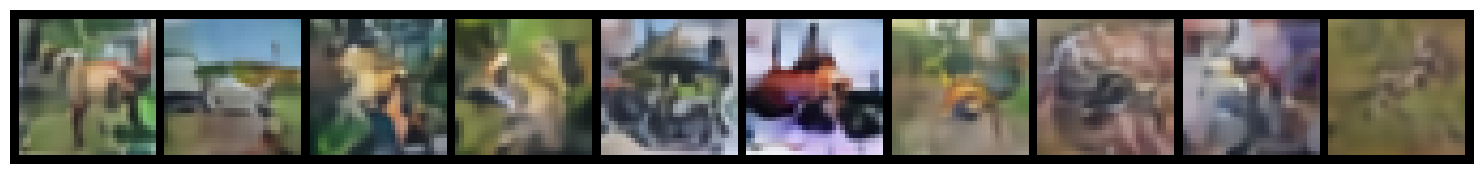

In [64]:
plot_images(spae_images[start: end])

In [36]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores

# LPIPS between original and original attacks
import torch
img_orig = adv_images.detach().cpu() # image should be RGB, IMPORTANT: normalized to [-1,1]
# img_modf = spae_images.detach().cpu()
img = x[0].detach().cpu()

orig_lpips = loss_fn_alex(img, img_orig)
# modf_lpips = loss_fn_alex(img, img_modf)
print("Average LPIPS score of original adversarial attack: ", orig_lpips.flatten().mean())
# print("Average LPIPS score of modifed adversarial attack: ", modf_lpips.flatten().mean())

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/harsh/anaconda3/envs/py38/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Average LPIPS score of original adversarial attack:  tensor(nan, grad_fn=<MeanBackward0>)
